## Imports and common functions

In [1]:
import os
import json

# analysis
import pandas as pd
import numpy as np
import reverse_geocoder as rg

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('config.json') as json_data:
    d = json.load(json_data)
    GOOGLE_MAPS_API_KEY = d['google-maps-key']

## Load in data
Check if CSV data exists, otherwise parse .dat files into csv

In [3]:
def load_dat_file(file_name, n_components):  
    """
    Loads in .dat files as lists. 
    
    Inputs: 
        file_name (string): name of file to load in
        n_components (int): number of components in row
        
    Outputs:
        (list): list of rows in data file
    """
    new_lines = []
    with open(file_name) as input_file:
        for line in input_file:
            new_line = [x.strip() for x in line.split('|')]
            
            if len(new_line) == n_components:
                new_lines.append(new_line)
    return new_lines

def read_data(directory, file_name, components=None):
    """
    Check to see if csv file exists, if not read in and parse dat file
    
    Inputs:
        directory (string): directory where data is stored
        file_name (string): file name WITHOUT extension
        components (int): number of components if reading from dat file
        
    Output:
        (pandas dataframe): dataframe with formatted 
    """
    if os.path.isfile(directory + file_name + '.csv'):
        print 'Reading csv file: ' + directory + file_name + '.csv'
        return pd.read_csv(directory + file_name + '.csv')
    else:
        if components is not None:
            print 'Parsing dat file: ' + directory + file_name + '.dat'
            # load in data 
            raw_data = load_dat_file(directory + file_name + '.dat', components)
            data_df = pd.DataFrame(raw_data[1:], columns=raw_data[0])
            
            # drop all rows with blank entires
            data_df.replace('', np.nan, inplace=True)
            data_df.dropna(inplace=True)
            
            # save as csv
            data_df.to_csv(directory + file_name + '.csv', index=False)
            
            # return parsed data
            return data_df
        else:
            return None

In [161]:
# read in each data frame
checkin_df = read_data('./raw_data/', 'checkins', components=6)
ratings_df = read_data('./raw_data/', 'ratings', components=3)
socialgraph_df = read_data('./raw_data/', 'socialgraph', components=2)
user_df = read_data('./raw_data/', 'users', components=3)
venues_df = read_data('./raw_data/', 'venues', components=3)

Reading csv file: ./raw_data/checkins.csv
Reading csv file: ./raw_data/ratings.csv
Reading csv file: ./raw_data/socialgraph.csv
Reading csv file: ./raw_data/users.csv
Reading csv file: ./raw_data/venues.csv


## Data Cleaning

### Select venues in United States only

In [162]:
# assign cities and countries
current_reverse_geocode = rg.search(zip(venues_df['latitude'], venues_df['longitude']))
cities = [x['name'] for x in current_reverse_geocode]
states = [x['admin1'] for x in current_reverse_geocode]
countries = [x['cc'] for x in current_reverse_geocode]

venues_df['city'] = cities
venues_df['state'] = states
venues_df['country'] = countries

In [163]:
# select venues where country are in US
venues_df = venues_df[venues_df['country'] == 'US']

# select checkins and ratings that are only for venues in US 
checkin_df = checkin_df[checkin_df['venue_id'].isin(venues_df['id'])]
ratings_df = ratings_df[ratings_df['venue_id'].isin(venues_df['id'])]

# select users who made checkins or ratings
user_df = user_df[user_df['id'].isin(checkin_df['user_id'] + ratings_df['user_id'])]
socialgraph_df = socialgraph_df[socialgraph_df['first_user_id'].isin(user_df['id'])]

## Exploratory Analysis

### Visualize number of venues by State and City

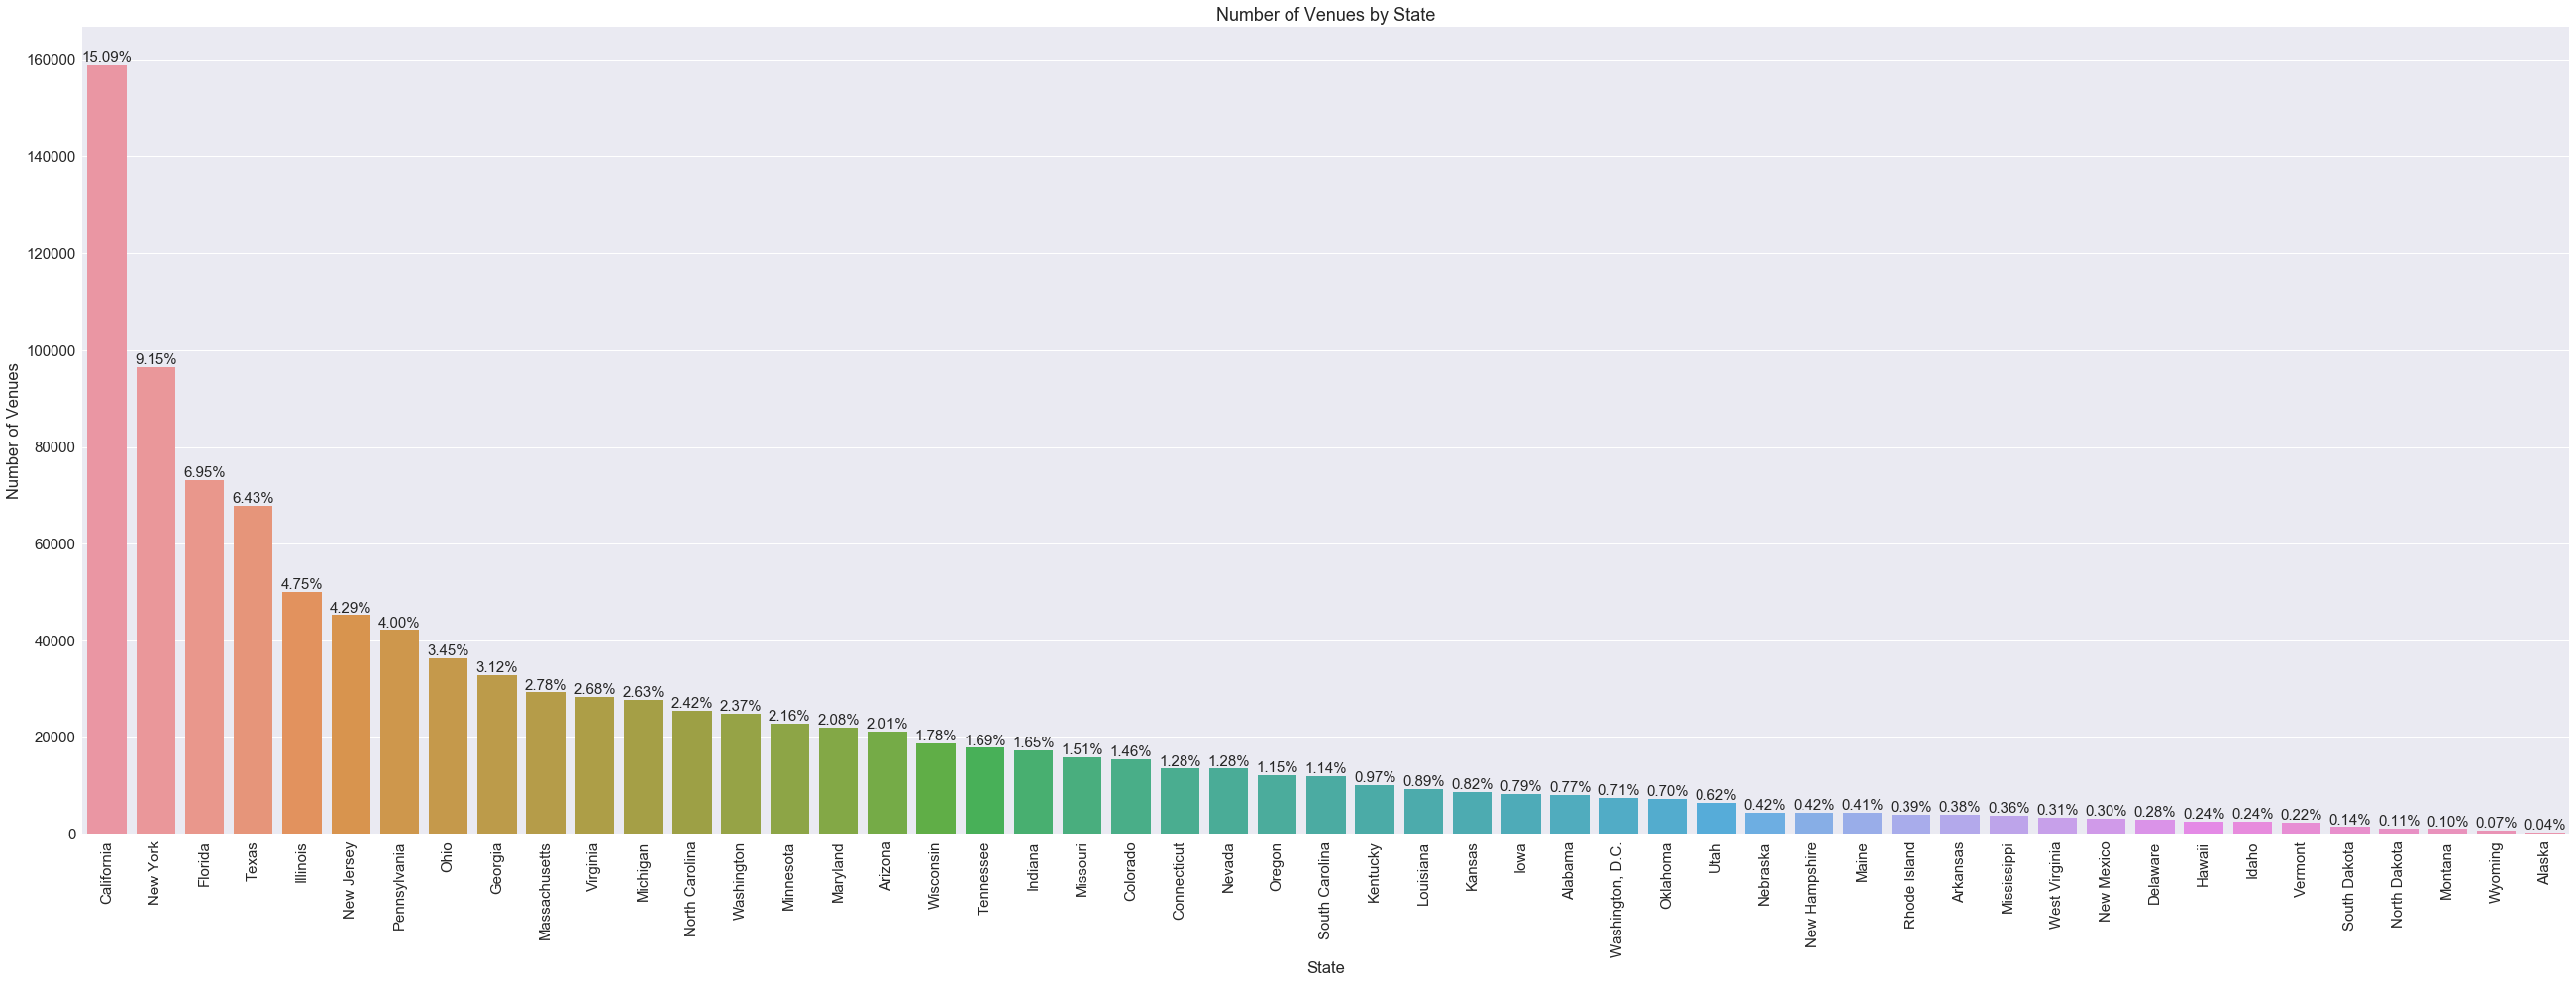

In [53]:
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
state_ordering = venues_df['state'].value_counts().index.tolist()
state_count = sns.countplot(venues_df['state'], order=state_ordering)
state_count.set_xlabel('State')
state_count.set_ylabel('Number of Venues')
state_count.set_title('Number of Venues by State')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 

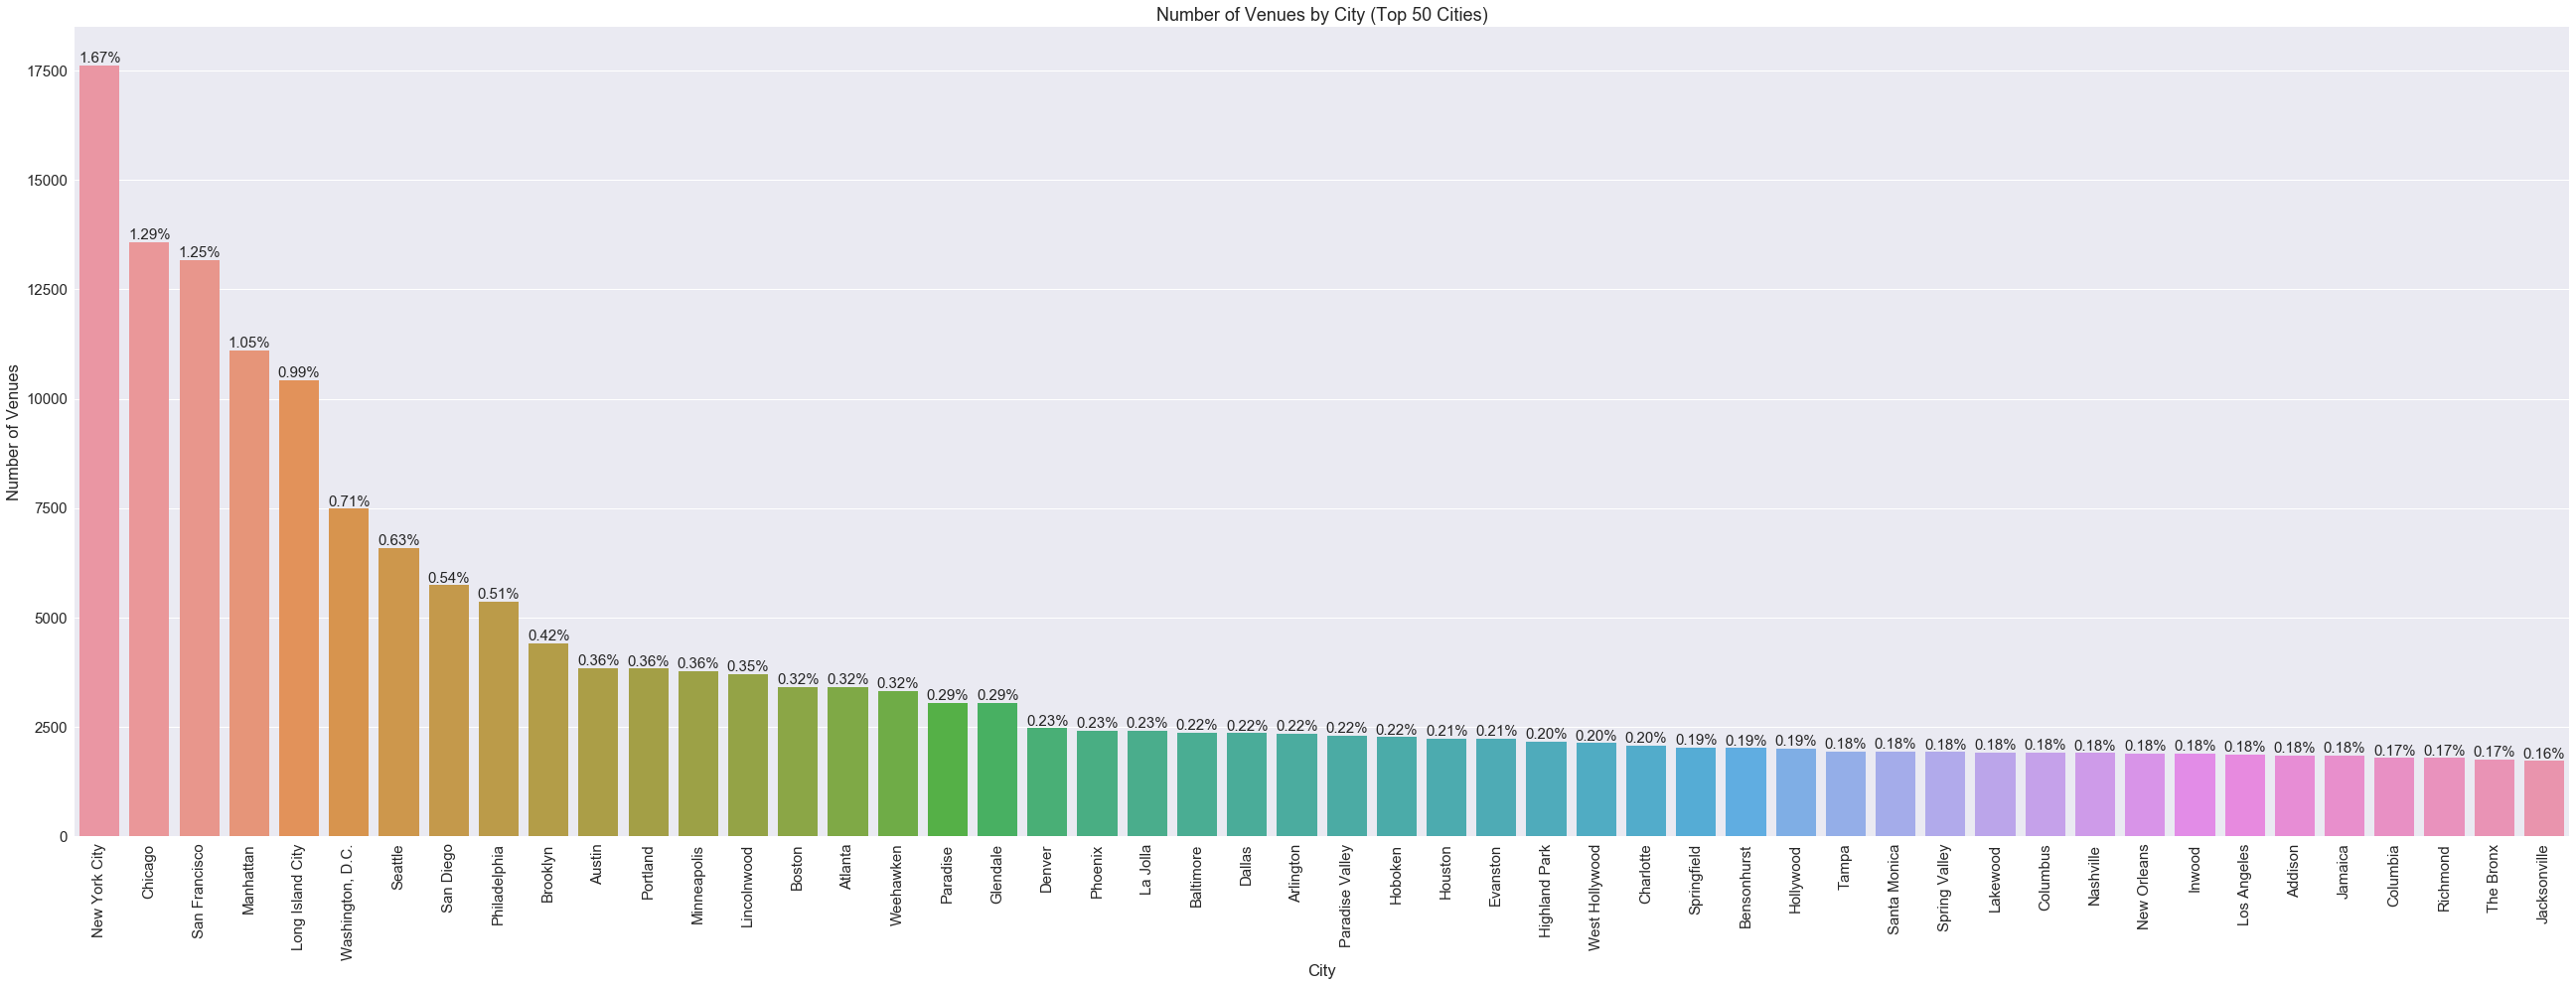

In [54]:
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
city_ordering = venues_df['city'].value_counts().index.tolist()[0:50]
city_count = sns.countplot(venues_df[venues_df['city'].isin(city_ordering)]['city'], order=city_ordering)
city_count.set_xlabel('City')
city_count.set_ylabel('Number of Venues')
city_count.set_title('Number of Venues by City (Top 50 Cities)')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 

### How are people connected across cities and states? 

In [56]:
# assign cities and countries
current_reverse_geocode = rg.search(zip(user_df['latitude'], user_df['longitude']))
cities = [x['name'] for x in current_reverse_geocode]
states = [x['admin1'] for x in current_reverse_geocode]
countries = [x['cc'] for x in current_reverse_geocode]

user_df['city'] = cities
user_df['state'] = states
user_df['country'] = countries

# select only users who are in the United States
user_df = user_df[user_df['country'] == 'US']

In [57]:
# select only graph edges where both nodes ids appear in user_df 
socialgraph_df = socialgraph_df[(socialgraph_df['first_user_id'].isin(user_df['id'])) &
                                  (socialgraph_df['second_user_id'].isin(user_df['id']))]

In [66]:
# create social graph by location
location_socialgraph_df = pd.concat([socialgraph_df.merge(user_df[['id', 'city', 'state']], left_on='first_user_id', right_on='id', how='left')[['first_user_id', 'second_user_id', 'city', 'state']],
                                     socialgraph_df.merge(user_df[['id', 'city', 'state']], left_on='second_user_id', right_on='id', how='left')[['city', 'state']]], axis=1)
location_socialgraph_df.columns = ['first_user_id', 'second_user_id',
                                   'first_user_city', 'first_user_state',
                                   'second_user_city', 'second_user_state']

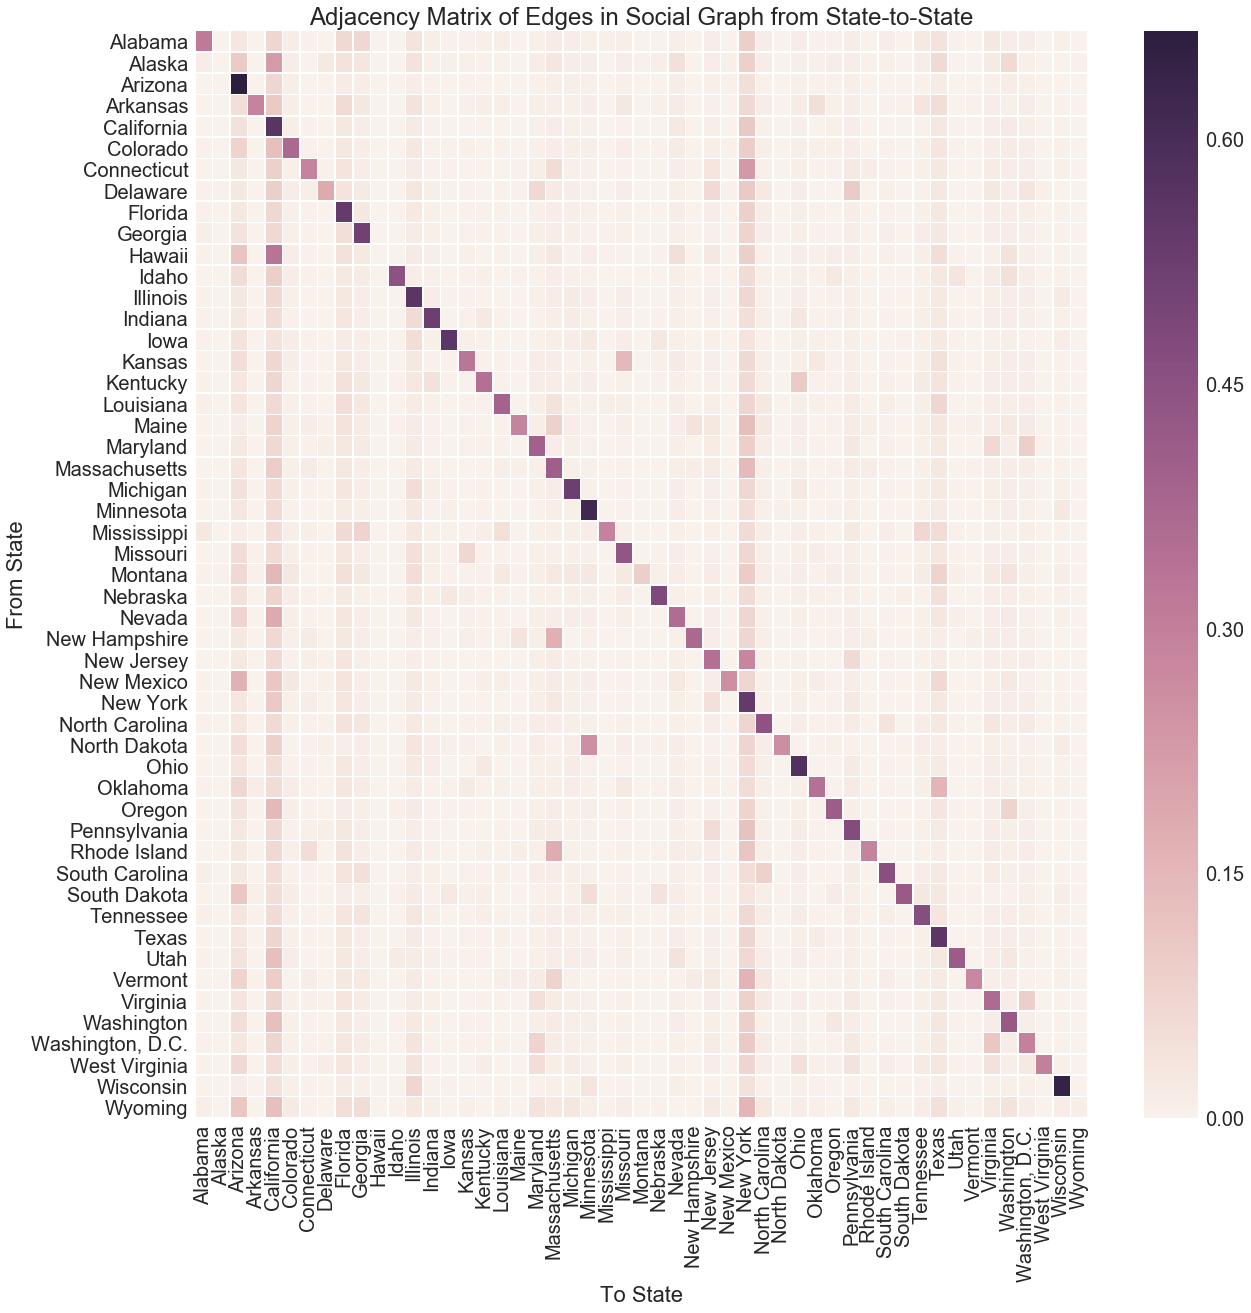

In [140]:
# create and state-level adj matrix and visualize
state_social_adj = pd.crosstab(location_socialgraph_df.first_user_state, location_socialgraph_df.second_user_state,
                               normalize='index')

fig, ax = plt.subplots(figsize=(20, 20));
sns.despine();
sns.set(font_scale=2);
state_graph_heatmap = sns.heatmap(state_social_adj, linewidths=.5)
state_graph_heatmap.set_xlabel('To State')
state_graph_heatmap.set_ylabel('From State')
state_graph_heatmap.set_title('Adjacency Matrix of Edges in Social Graph from State-to-State')

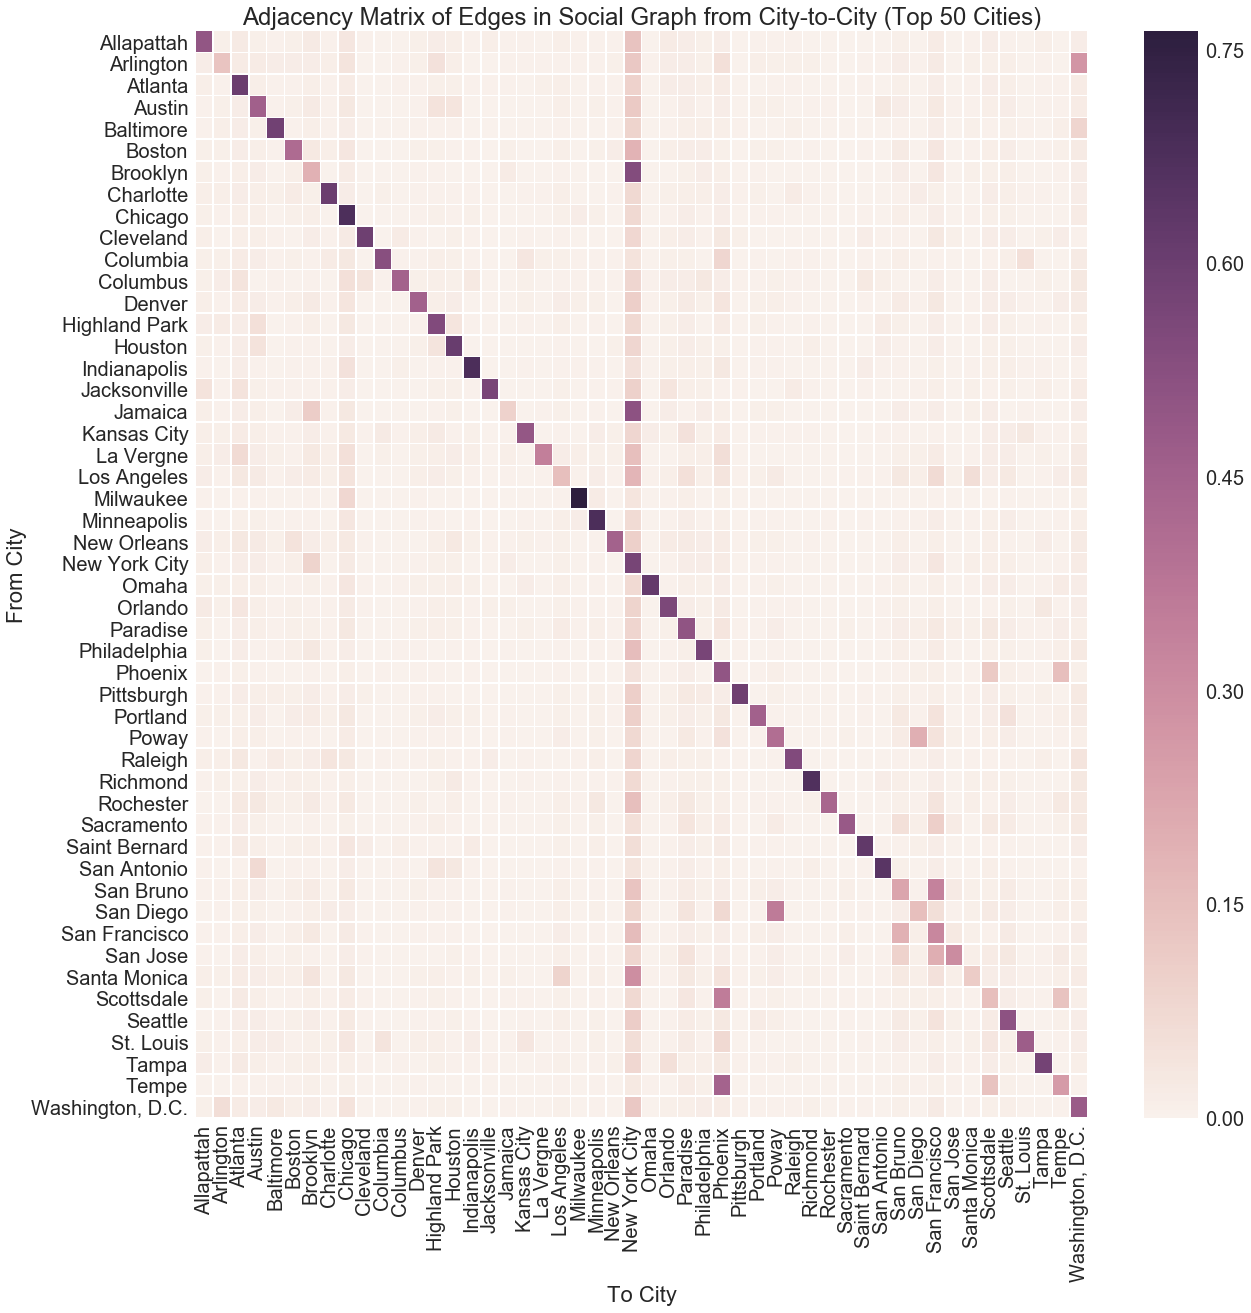

In [142]:
# create and cities-level adj matrix and visualize for top 50 cities with venues
top_cities = user_df['city'].value_counts().index.tolist()[0:50]
top_cities_location_socialgraph_df = location_socialgraph_df[(location_socialgraph_df['first_user_city'].isin(top_cities)) &
                                                             (location_socialgraph_df['second_user_city'].isin(top_cities))]
city_social_adj = pd.crosstab(top_cities_location_socialgraph_df.first_user_city,
                              top_cities_location_socialgraph_df.second_user_city,
                              normalize='index')

fig, ax = plt.subplots(figsize=(20, 20));
sns.despine();
sns.set(font_scale=2)
city_graph_heatmap = sns.heatmap(city_social_adj, linewidths=.5)
city_graph_heatmap.set_xlabel('To City')
city_graph_heatmap.set_ylabel('From City')
city_graph_heatmap.set_title('Adjacency Matrix of Edges in Social Graph from City-to-City (Top 50 Cities)')

KeyError: 'city'

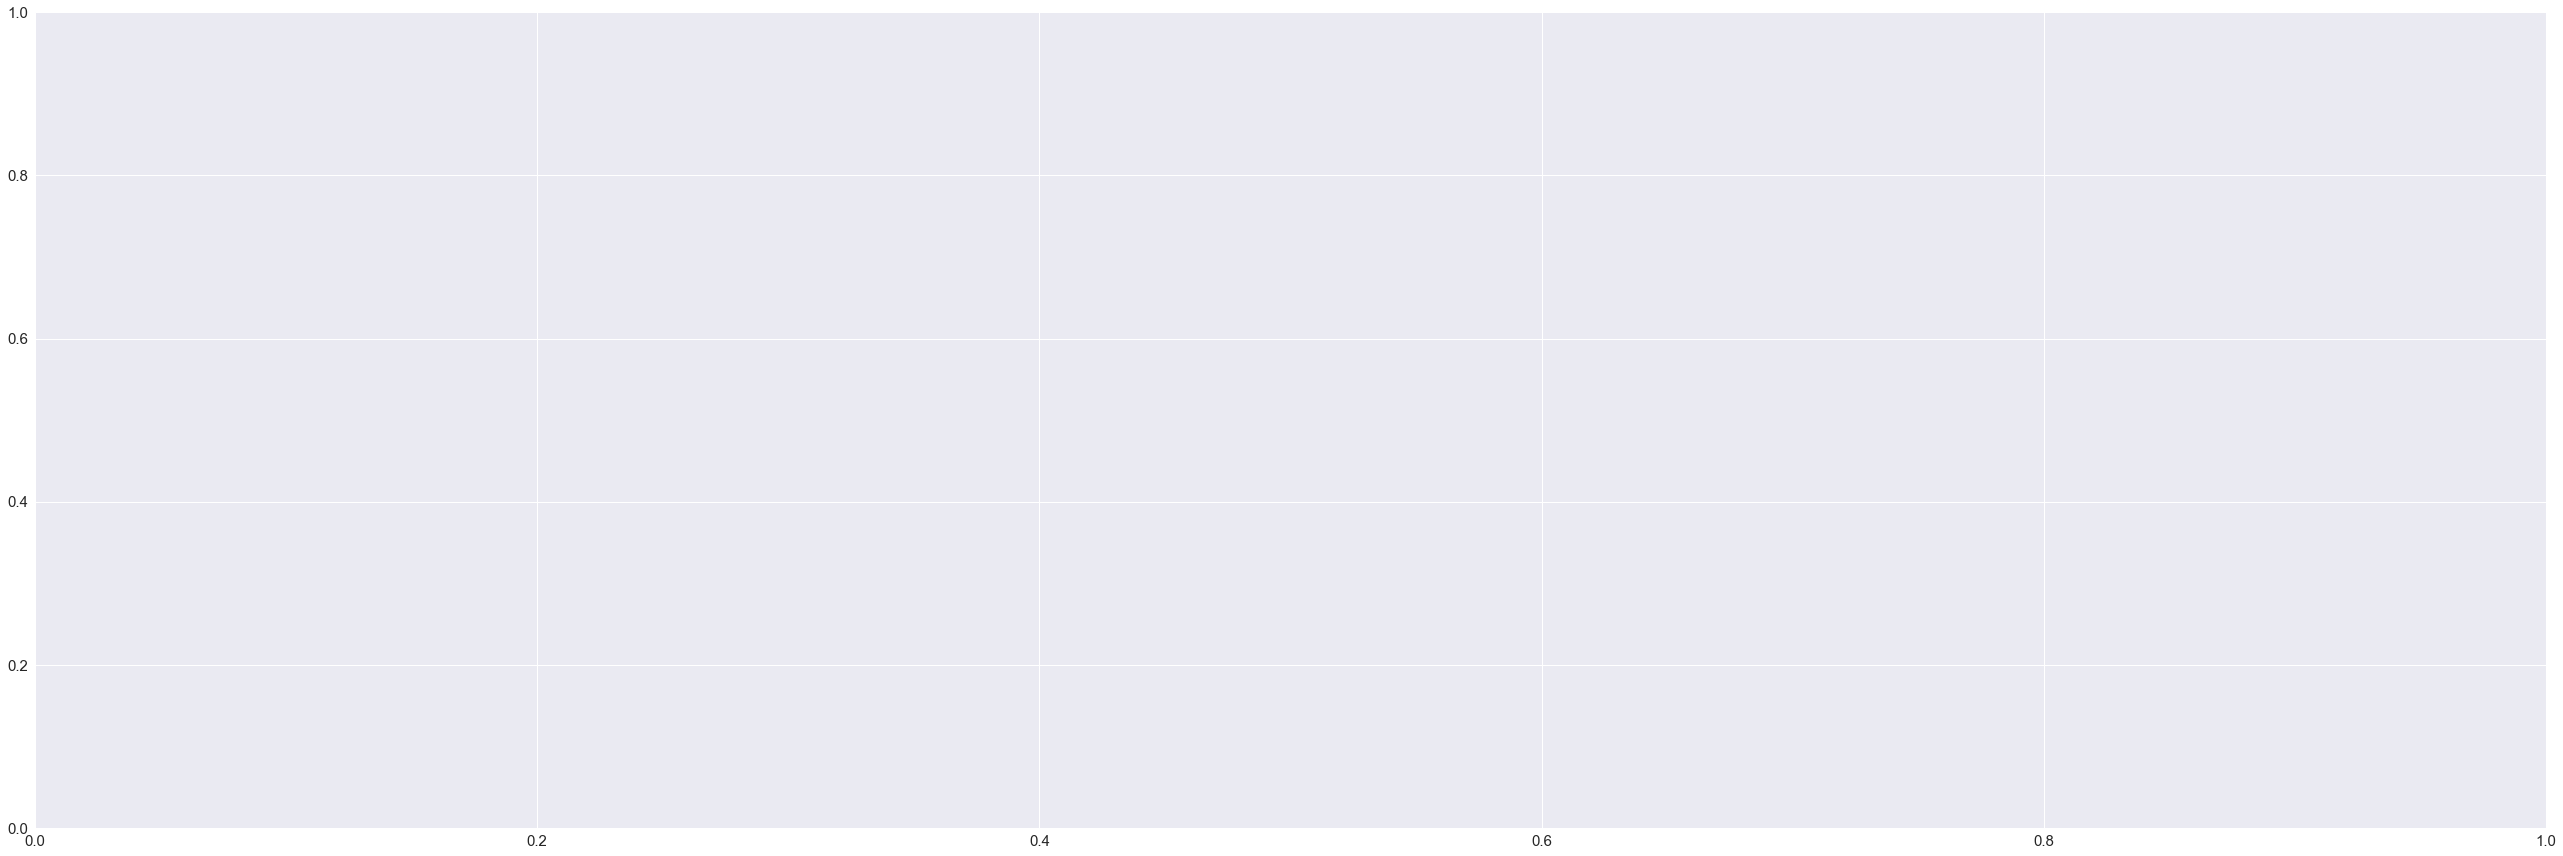

In [186]:
# Visualize number of people in each city
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
city_ordering = user_df['city'].value_counts().index.tolist()[0:50]
city_count = sns.countplot(user_df[user_df['city'].isin(city_ordering)]['city'], order=city_ordering)
city_count.set_xlabel('City')
city_count.set_ylabel('Number of Venues')
city_count.set_title('Number of Venues by City (Top 50 Cities)')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 

In [187]:
user_df

,id,latitude,longitude
19,96418,-6.211544,106.845172
20,96403,-6.211544,106.845172
22,96383,-6.950000,107.400000
41,155105,50.797090,4.416610
42,155101,32.059925,34.785126
51,181247,53.543564,-113.490452
77,155159,37.566535,126.977969
110,175150,50.850300,4.351710
114,713280,-1.265386,116.831200
115,713279,-0.789275,113.921327


### How do user's check-in to locations across states and cities?

In [167]:
# assign cities and countries
current_reverse_geocode = rg.search(zip(checkin_df['latitude'], checkin_df['longitude']))
cities = [x['name'] for x in current_reverse_geocode]
states = [x['admin1'] for x in current_reverse_geocode]
countries = [x['cc'] for x in current_reverse_geocode]

checkin_df['city'] = cities
checkin_df['state'] = states
checkin_df['country'] = countries

# select only users who are in the United States
checkin_df = checkin_df[checkin_df['country'] == 'US']

In [180]:
# compute summary stats of checkins by user
checkins_by_user = pd.DataFrame({'count': checkin_df.groupby(['user_id'])['id'].count()}).reset_index()
checkins_by_user['count'].describe()

count    152839.000000
mean          2.429249
std           2.448010
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          48.000000
Name: count, dtype: float64

In [168]:
# get unique contributions in each city for each user
checkin_byuser_city = pd.DataFrame({'unique_location': checkin_df.groupby(['user_id'])['city'].unique()}).reset_index()
checkin_byuser_city['unique_location_count'] = checkin_byuser_city.unique_location.apply(len)

# get unique contributions in each city for each user
checkin_byuser_state = pd.DataFrame({'unique_location': checkin_df.groupby(['user_id'])['state'].unique()}).reset_index()
checkin_byuser_state['unique_location_count'] = checkin_byuser_state.unique_location.apply(len)

In [183]:
# compute summary stats of checkins in unique cities
checkin_byuser_city['unique_location_count'].describe()

count    152839.000000
mean          1.000059
std           0.007673
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: unique_location_count, dtype: float64

In [184]:
# compute summary stats of checkins in unique states
checkin_byuser_state['unique_location_count'].describe()

count    152839.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: unique_location_count, dtype: float64